# Regression

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.formula.api as sm
import statsmodels.api as sma
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split

from tools import *

In [81]:
db = pd.read_csv("data/player_stats_extended.csv")
db = db_to_numeric(db)

db.head()

,PLAYER_ID,PLAYER_NAME,SEASON,SEASON_NUM,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,USG_PCT,...,AVG_DRIB_PER_TOUCH,ELBOW_TOUCHES,POST_TOUCHES,PAINT_TOUCHES,TEAM,INJURED ON,RETURNED,DAYS MISSED,INJURED_TYPE,INJURY_SEVERITY
0,1630639,A.J. Lawson,22-23,22.5,22.0,78.0,179.0,13,4.8,0.182,...,0.62,0.0,0.0,0.2,NaN,NaN,NaN,NaN,NaN,NaN
1,1631260,AJ Green,22-23,22.5,23.0,77.0,190.0,32,9.4,0.160,...,1.84,0.1,0.0,0.3,NaN,NaN,NaN,NaN,NaN,NaN
2,1631100,AJ Griffin,22-23,22.5,19.0,78.0,220.0,66,19.4,0.174,...,1.49,0.4,0.0,0.7,NaN,NaN,NaN,NaN,NaN,NaN
3,203932,Aaron Gordon,22-23,22.5,27.0,80.0,235.0,61,30.1,0.206,...,2.11,1.8,2.1,6.8,Nuggets,NaN,2023-02-07,5.0,Sprained_ankle,Moderate
4,1628988,Aaron Holiday,22-23,22.5,26.0,72.0,185.0,57,13.7,0.128,...,3.82,0.1,0.0,0.4,NaN,NaN,NaN,NaN,NaN,NaN


## Number of injuries and age

### Scatter plots

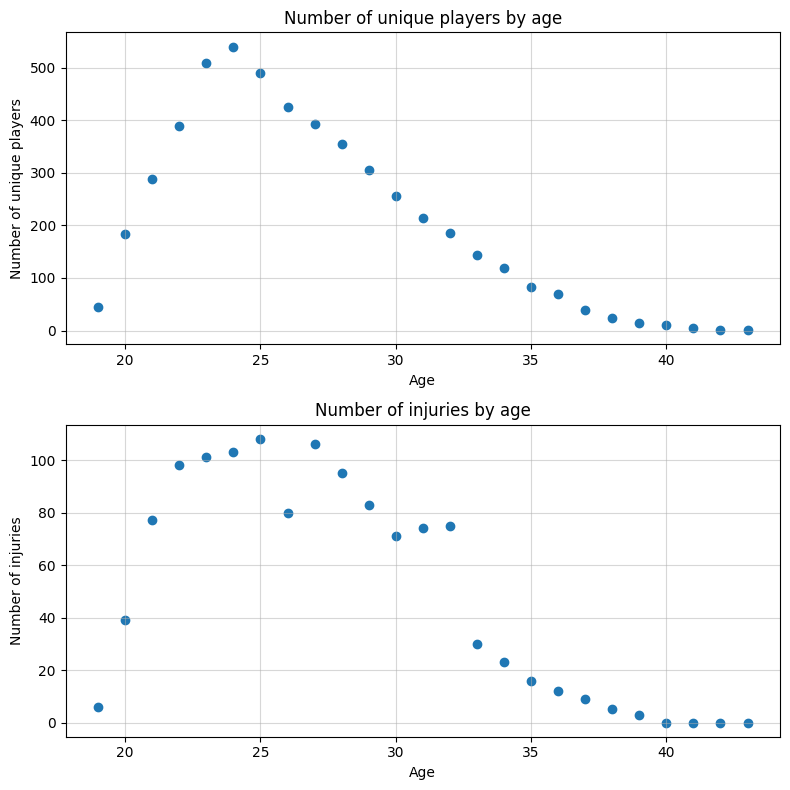

In [82]:
# db that contains the number of injuries for each age
injuries_age = pd.DataFrame([
    {
    'Age': int(a), 
    'injuries_number': len(db[(db["AGE"] == a) & (~db["INJURED_TYPE"].isna())]),
    'unique_players': len(db[db["AGE"] == a]["PLAYER_ID"].unique())
    }
    for a in sorted(db["AGE"].unique())
])

fig, ax = plt.subplots(2, 1, figsize=(8, 8))

ax[0].scatter(injuries_age["Age"], injuries_age["unique_players"])
ax[0].set_xlabel("Age")
ax[0].set_ylabel("Number of unique players")
ax[0].set_title("Number of unique players by age")
ax[0].grid(alpha=0.5)

ax[1].scatter(injuries_age["Age"], injuries_age["injuries_number"])
ax[1].set_xlabel("Age")
ax[1].set_ylabel("Number of injuries")
ax[1].set_title("Number of injuries by age")
ax[1].grid(alpha=0.5)

# ax[1].scatter(injuries_age["Age"], injuries_age["injuries_number"] / injuries_age["unique_players"])
# ax[1].set_xlabel("Age")
# ax[1].set_ylabel("Frequency of injuries")
# ax[1].set_title("Frequency of injuries by age")
# ax[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()

This already doesn't look especially promising: the trend that the first graph (Number of injuries by age) shows is most probably influenced by the different age distribution in the dataset (as in the graph below).

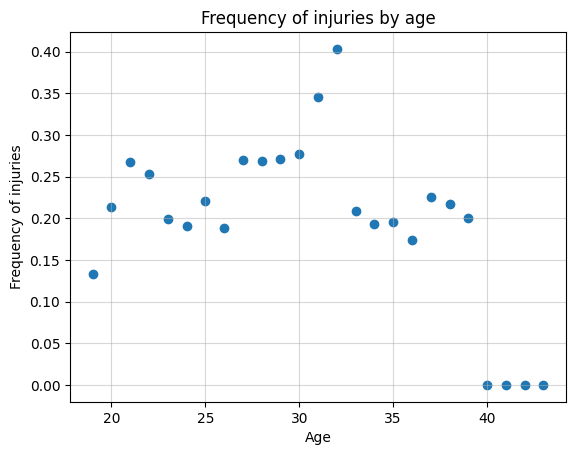

In [83]:
plt.scatter(injuries_age["Age"], injuries_age["injuries_number"] / injuries_age["unique_players"])
plt.xlabel("Age")
plt.ylabel("Frequency of injuries")
plt.title("Frequency of injuries by age")
plt.grid(alpha=0.5)
plt.show()

### Linear regression

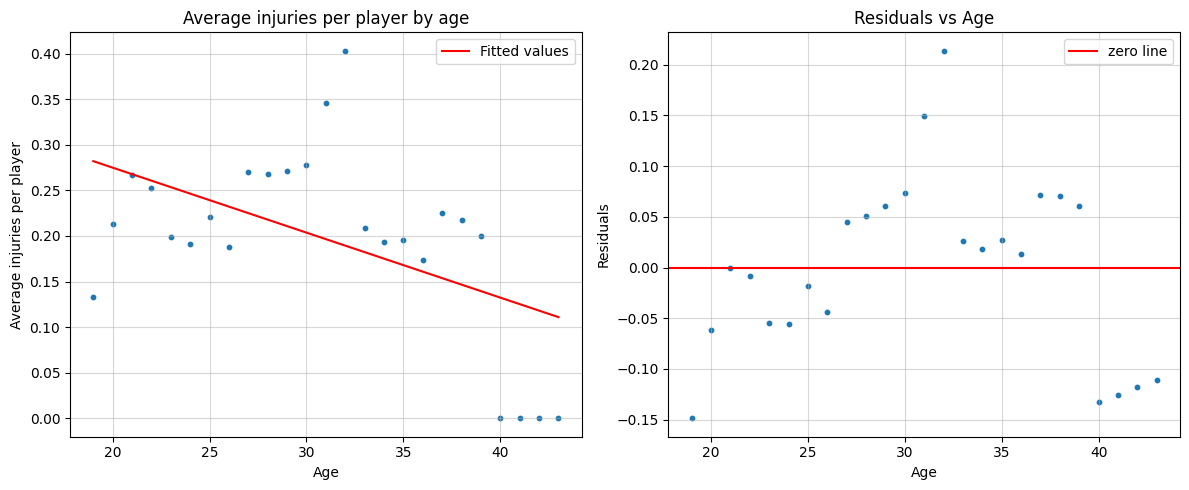

In [84]:
injuries_age_stats = pd.DataFrame({
    'Age': injuries_age['Age'],
    'injuries_ratio': injuries_age['injuries_number']/injuries_age['unique_players']
})

res = sm.ols('injuries_ratio ~ Age', data=injuries_age_stats).fit()
residuals = res.resid

summary = plot_linear_regression(injuries_age_stats, res, residuals)

In [85]:
print(summary)

                            OLS Regression Results                            
Dep. Variable:         injuries_ratio   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     7.946
Date:                Sun, 18 May 2025   Prob (F-statistic):            0.00974
Time:                        11:16:09   Log-Likelihood:                 25.447
No. Observations:                  25   AIC:                            -46.89
Df Residuals:                      23   BIC:                            -44.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4175      0.080      5.188      0.0

### Age recovery time

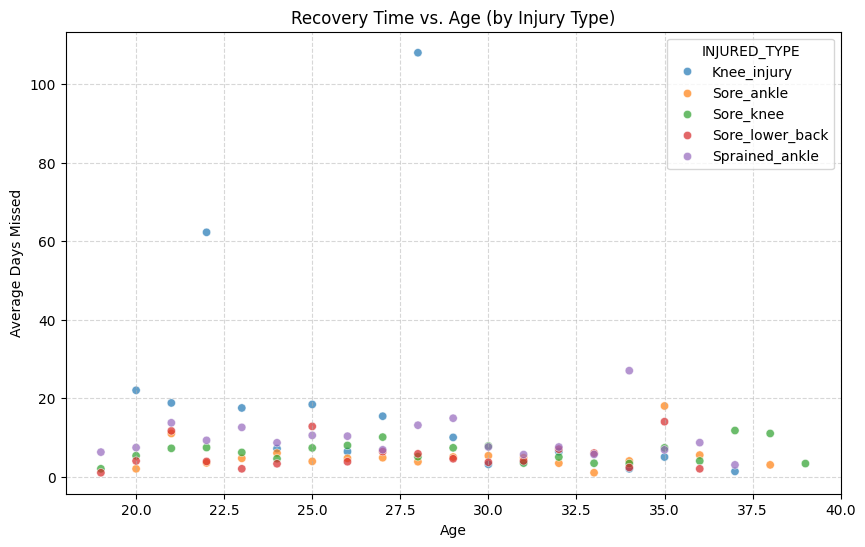

In [86]:
age_recoverytime = db[["AGE", "DAYS MISSED", "INJURED_TYPE"]].copy()
recovery_by_age_and_type = age_recoverytime.groupby(['INJURED_TYPE', 'AGE'])['DAYS MISSED'].mean().reset_index()

age_recoverytime.head()

plt.figure(figsize=(10, 6))

# Create the scatter plot
sns.scatterplot(
    data=recovery_by_age_and_type,
    x='AGE',
    y='DAYS MISSED',
    hue='INJURED_TYPE',
    alpha=0.7  # Adjust transparency for better readability
)

# Add title and labels
plt.title("Recovery Time vs. Age (by Injury Type)")
plt.xlabel("Age")
plt.ylabel("Average Days Missed")

# Show grid for better visualization
plt.grid(True, linestyle="--", alpha=0.5)

# Display the plot
plt.show()

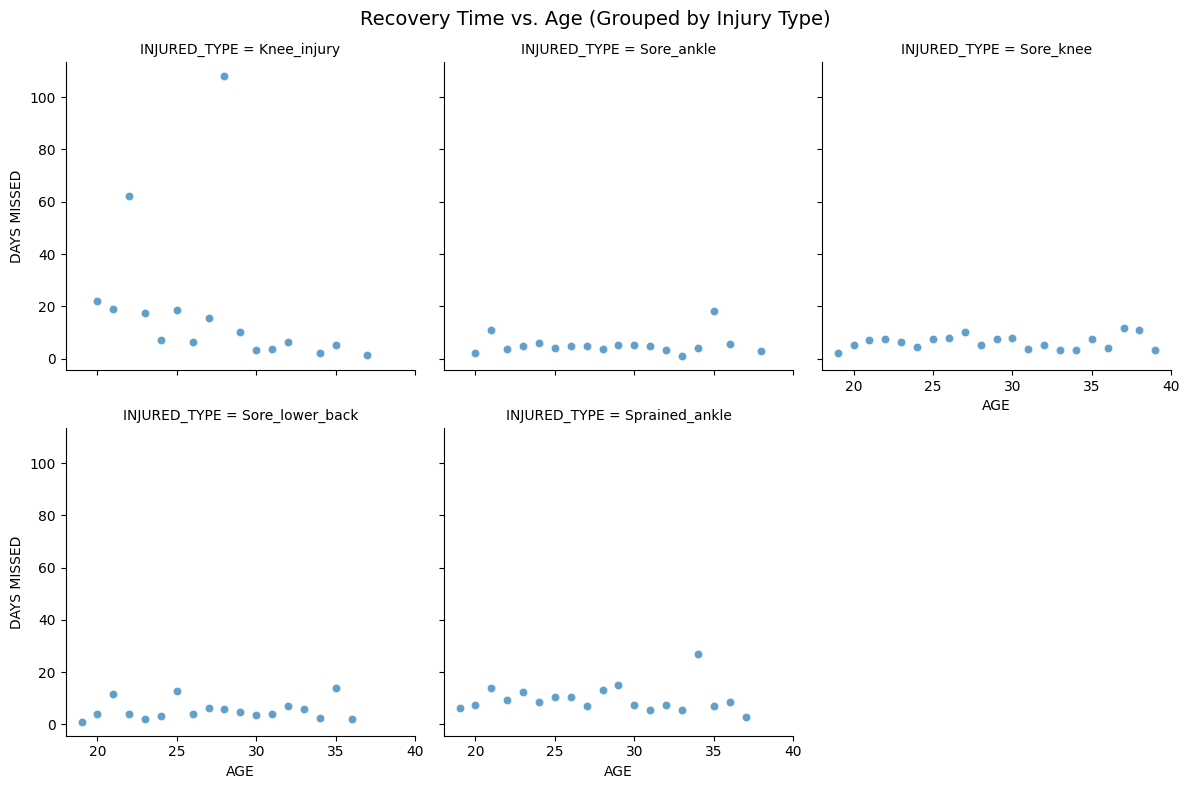

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the FacetGrid with each injury type as a separate plot
g = sns.FacetGrid(recovery_by_age_and_type, col="INJURED_TYPE", col_wrap=3, height=4, sharex=True, sharey=True)

# Map scatter plots onto each subplot
g.map_dataframe(sns.scatterplot, x="AGE", y="DAYS MISSED", alpha=0.7)

# Add title to the overall figure
g.fig.suptitle("Recovery Time vs. Age (Grouped by Injury Type)", fontsize=14)

# Adjust layout
g.tight_layout()

# Show the plots
plt.show()

## Mutliple linear regression

### Multiple regression on total number of injuries

We aim to find the attributes that best predicts number of injuries among players

In [88]:
# First create the dataframe
injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[(db["PLAYER_ID"] == p) & (db["INJURED_TYPE"].notna())]),
        'age': db[db["PLAYER_ID"] == p]["AGE"].iloc[0],
        'games_played': db[db["PLAYER_ID"] == p]["GP"].sum(),
        'minutes': db[db["PLAYER_ID"] == p]["MIN"].mean(),
    }
    for p in db["PLAYER_ID"].unique()
])

train_data, test_data = train_test_split(injuries_multiple, test_size=0.2, random_state=42)

res_train = sm.ols('injuries_number ~ age + games_played + minutes', data=train_data).fit()
res_test = sm.ols('injuries_number ~ age + games_played + minutes', data=test_data).fit()

# ages_count = pd.DataFrame(injuries_multiple["age"].value_counts())
# for age in db["AGE"].unique():
#     if age not in ages_count.index:
#         ages_count.loc[age] = 0

# ages_count = ages_count.sort_index()

pd.DataFrame(injuries_multiple["age"].value_counts()).sort_index().head(50)

,count
age,
19.0,11
20.0,36
21.0,64
22.0,91
23.0,141
24.0,154
25.0,134
26.0,109
27.0,108


Training Set:
                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     445.3
Date:                Sun, 18 May 2025   Prob (F-statistic):          9.57e-190
Time:                        11:16:10   Log-Likelihood:                -1940.3
No. Observations:                1112   AIC:                             3889.
Df Residuals:                    1108   BIC:                             3909.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.1198      0.283

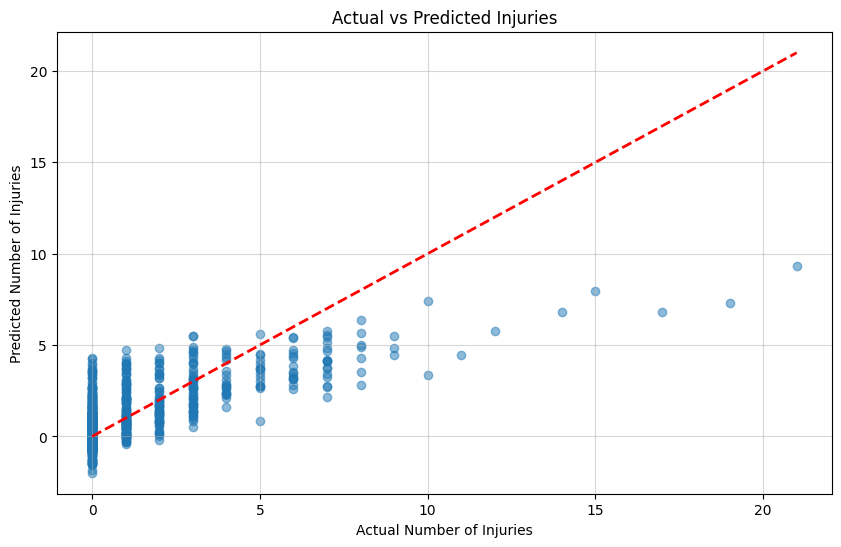

partial regression plot (training set):


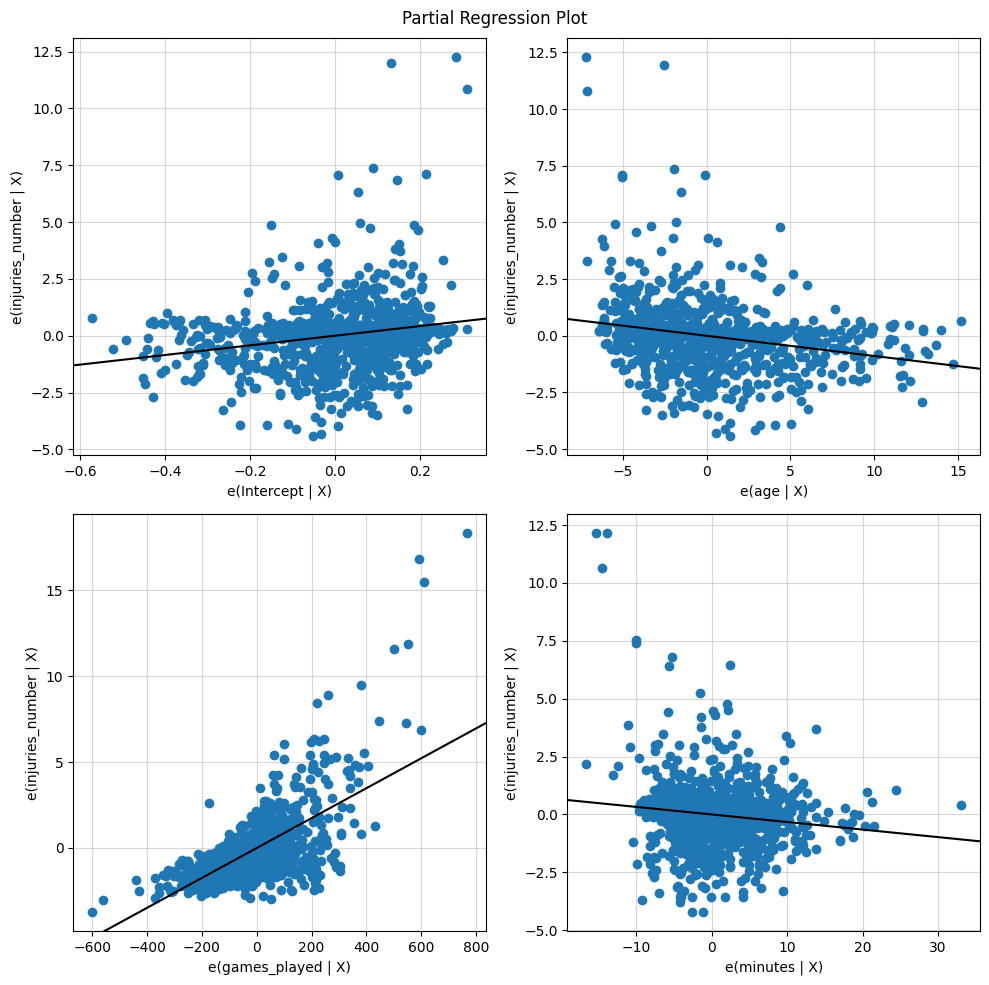

multiple regression plot (test set):


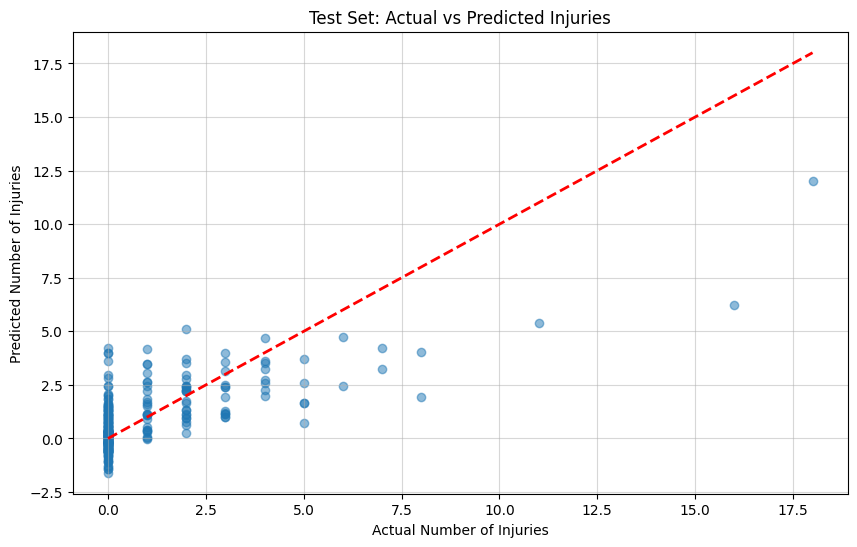

partial regression plot (test set):


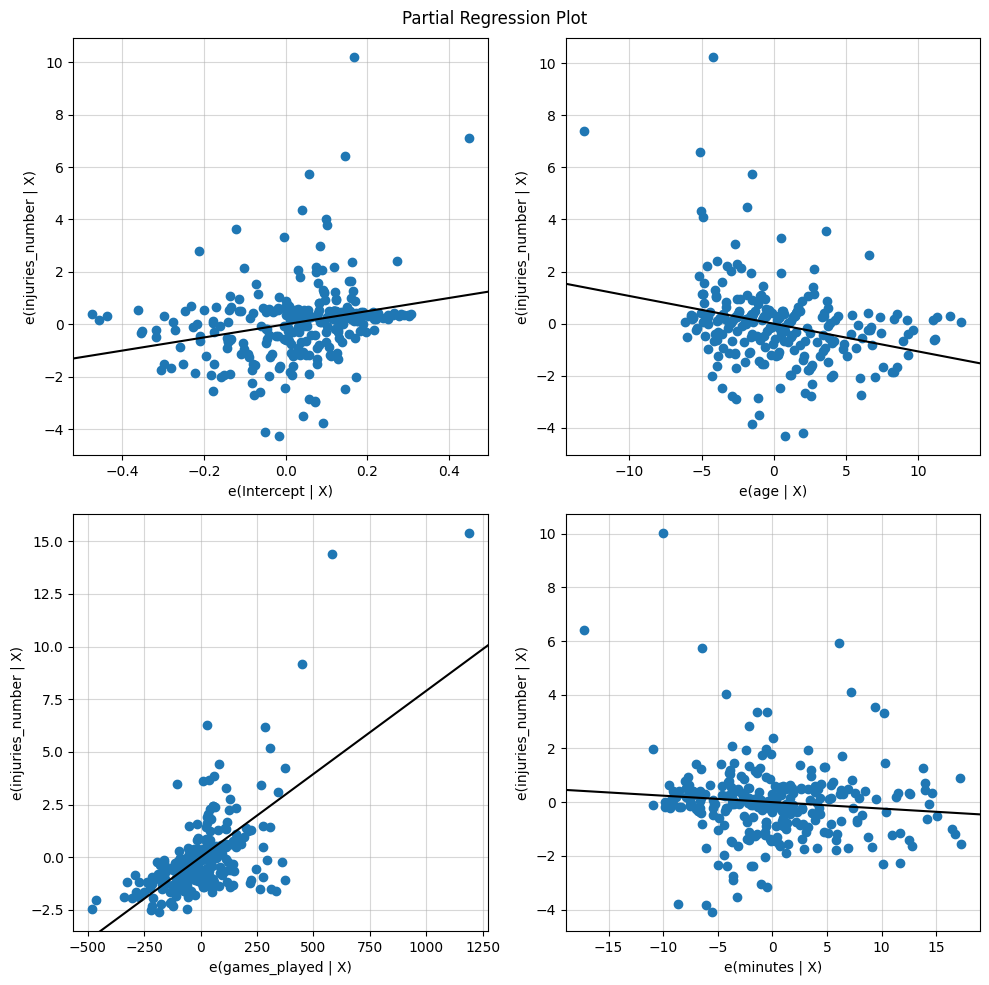

In [89]:
multiple_regression_result(
    res_train, res_test, injuries_multiple, test_data, train_data
)

Training Set:
                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     1158.
Date:                Sun, 18 May 2025   Prob (F-statistic):          1.77e-174
Time:                        11:16:12   Log-Likelihood:                -1982.7
No. Observations:                1112   AIC:                             3969.
Df Residuals:                    1110   BIC:                             3980.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.4270      0.057

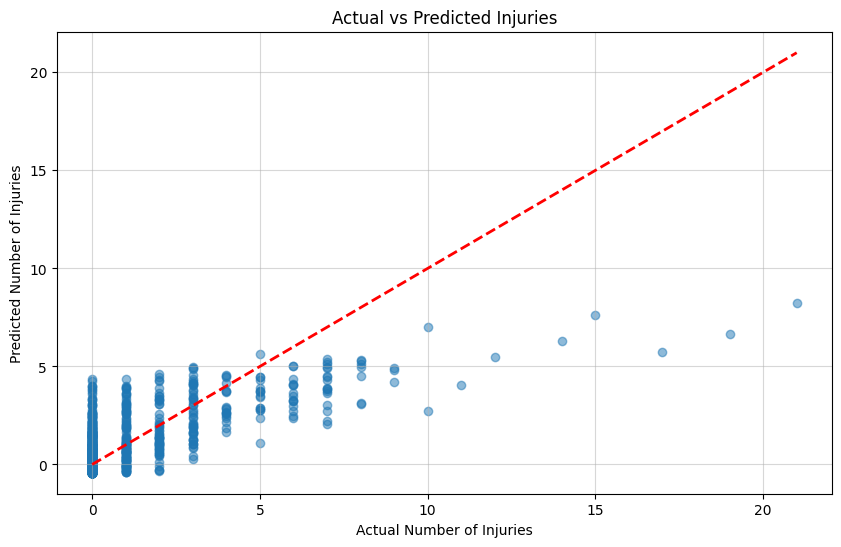

partial regression plot (training set):


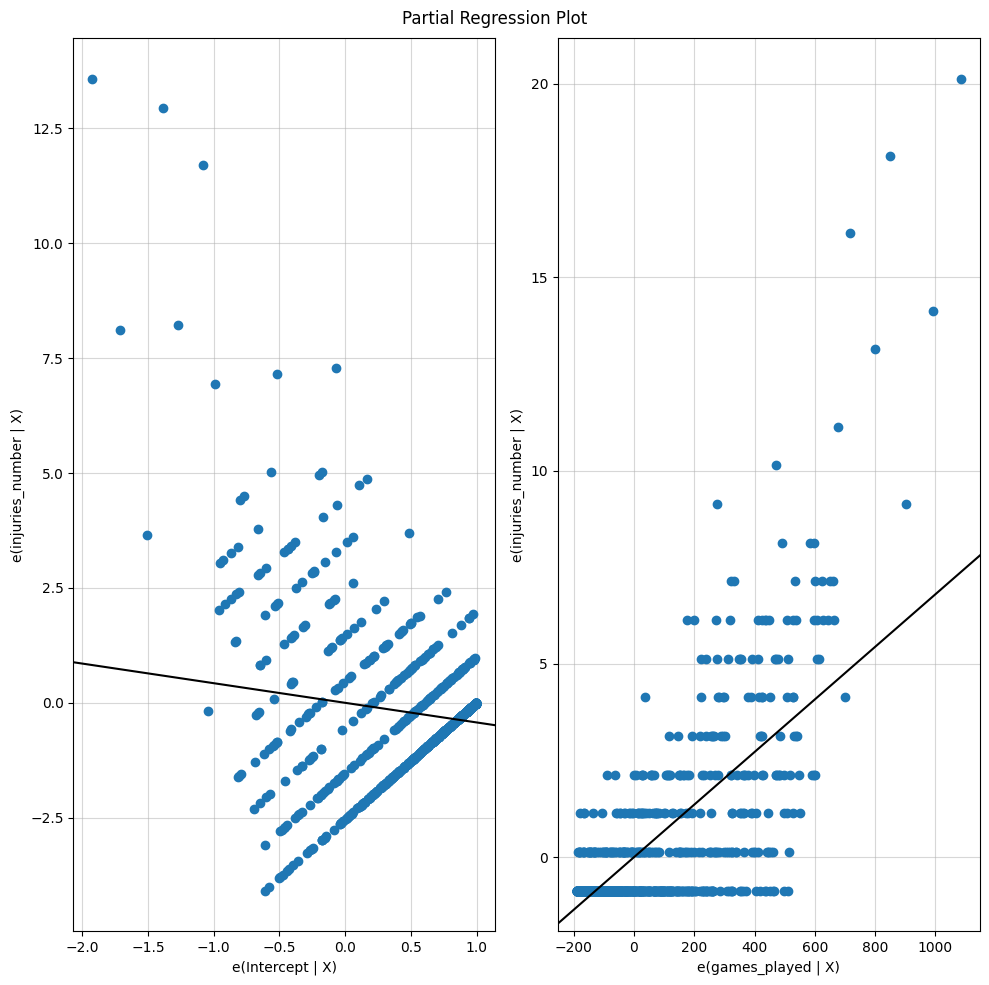

multiple regression plot (test set):


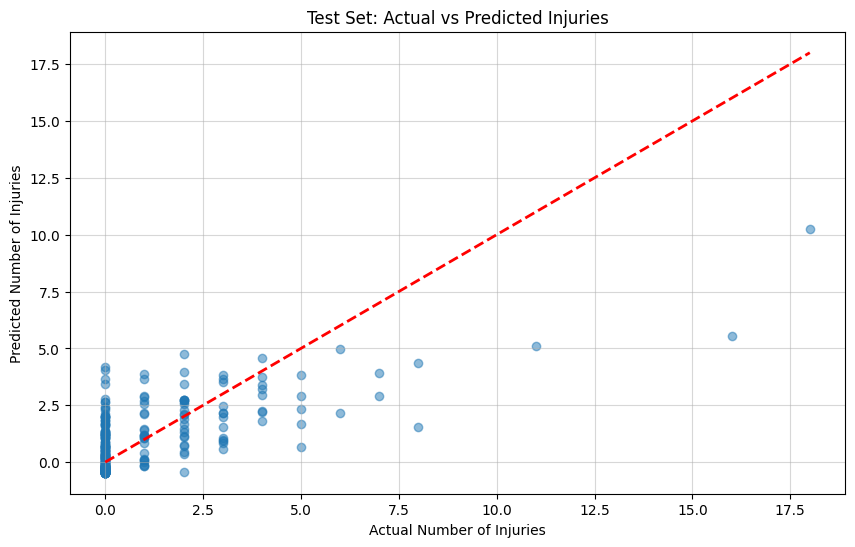

partial regression plot (test set):


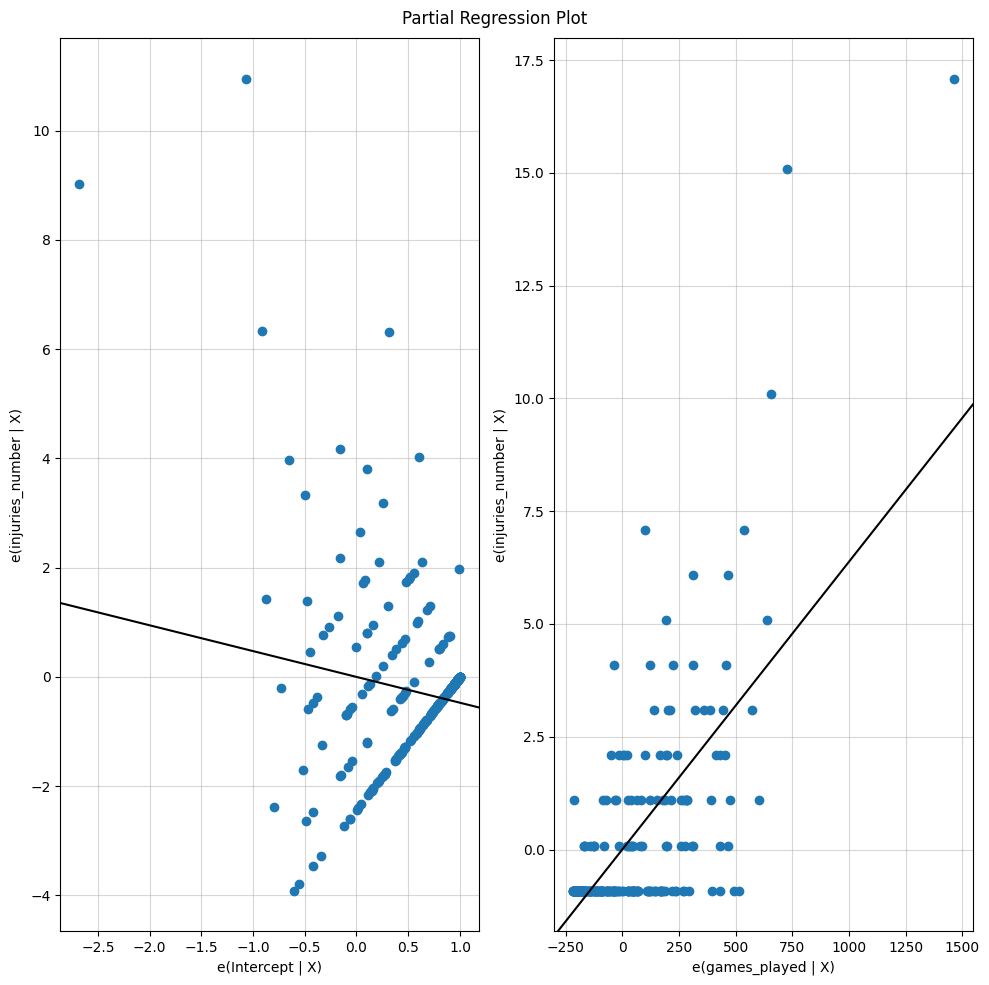

In [90]:
# First create the dataframe
injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[(db["PLAYER_ID"] == p) & (db["INJURED_TYPE"].notna())]),
        'age': db[db["PLAYER_ID"] == p]["AGE"].iloc[0],
        'games_played': db[db["PLAYER_ID"] == p]["GP"].sum(),
        'minutes': db[db["PLAYER_ID"] == p]["MIN"].mean(),
    }
    for p in db["PLAYER_ID"].unique()
])

train_data, test_data = train_test_split(injuries_multiple, test_size=0.2, random_state=42)

res_train = sm.ols('injuries_number ~ games_played', data=train_data).fit()
res_test = sm.ols('injuries_number ~ games_played', data=test_data).fit()

multiple_regression_result(
    res_train, res_test, injuries_multiple, test_data, train_data
)

                 Generalized Linear Model Regression Results                  
Dep. Variable:           injury_count   No. Observations:                 1112
Model:                            GLM   Df Residuals:                     1109
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1002.8
Date:                Sun, 18 May 2025   Deviance:                       731.17
Time:                        11:16:13   Pearson chi2:                     905.
No. Iterations:                    17   Pseudo R-squ. (CS):             0.5450
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2189      0.374      0.585

/Users/luciocanepa/Library/CloudStorage/OneDrive-UniversitätZürichUZH/Intro to Data Science/data_science_project/venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


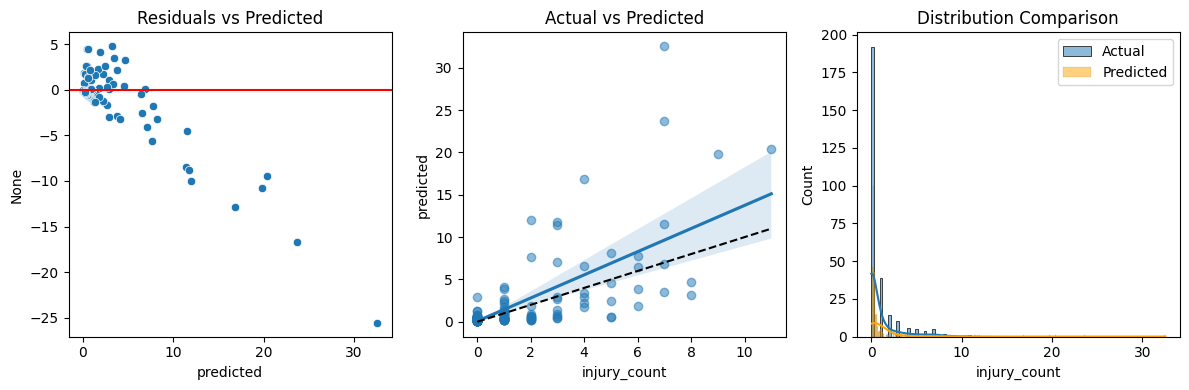


Overdispersion Test:
Pearson χ²/DF: 0.82
Values >1 indicate Negative Binomial was needed


In [91]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# 1. Create Proper Player-Level Dataset
player_injuries = db.groupby('PLAYER_ID').agg(
    age=('AGE', 'first'),
    games_played=('GP', 'sum'),
    total_minutes=('MIN', 'sum'),
    injury_count=('INJURED_TYPE', lambda x: x.notna().sum())
).reset_index()

# 2. Create Exposure (log games played)
player_injuries['log_games'] = np.log(player_injuries['games_played'] + 1e-8)

# 3. Train-Test Split
train, test = train_test_split(player_injuries, test_size=0.2, random_state=42)

# 4. Negative Binomial Regression (Best for overdispersed counts)
formula = 'injury_count ~ age + total_minutes'
nb_model = sm.GLM.from_formula(
    formula,  # Removed offset term since it was causing errors
    data=train,
    family=sm.families.NegativeBinomial()
).fit()

print(nb_model.summary())

# 5. Evaluate on Test Set
test['predicted'] = nb_model.predict(test)

# Calculate MSE/RMSE for comparison
mse = np.mean((test['injury_count'] - test['predicted'])**2)
print(f"\nTest MSE: {mse:.2f}, RMSE: {np.sqrt(mse):.2f}")

# 6. Diagnostic Plots
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))

# Residuals vs Predicted
plt.subplot(131)
sns.scatterplot(x=test['predicted'], y=test['injury_count'] - test['predicted'])
plt.axhline(0, color='red')
plt.title('Residuals vs Predicted')

# Actual vs Predicted
plt.subplot(132)
sns.regplot(x='injury_count', y='predicted', data=test, scatter_kws={'alpha':0.5})
plt.plot([0, test['injury_count'].max()], [0, test['injury_count'].max()], '--k')
plt.title('Actual vs Predicted')

# Distribution Check
plt.subplot(133)
sns.histplot(test['injury_count'], label='Actual', kde=True)
sns.histplot(test['predicted'], label='Predicted', kde=True, color='orange')
plt.title('Distribution Comparison')
plt.legend()

plt.tight_layout()
plt.show()

# 7. Overdispersion Check
print("\nOverdispersion Test:")
print(f"Pearson χ²/DF: {nb_model.pearson_chi2 / nb_model.df_resid:.2f}")
print("Values >1 indicate Negative Binomial was needed")

### Multiple regression on number of injuries by season

In [92]:
injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[(db["PLAYER_ID"] == p) & (db["SEASON_NUM"] == s) & (db["INJURED_TYPE"].notna())]),
        'age': db[db["PLAYER_ID"] == p]["AGE"].iloc[0],
        'games_played': db[(db["PLAYER_ID"] == p) & (db["SEASON_NUM"] == s)]["GP"].sum(),
        'minutes': db[(db["PLAYER_ID"] == p) & (db["SEASON_NUM"] == s)]["MIN"].mean(),
    }
    for p in db["PLAYER_ID"].unique()
    for s in db[db["PLAYER_ID"] == p]["SEASON_NUM"].unique()
])

train_data, test_data = train_test_split(injuries_multiple, test_size=0.2, random_state=42)

res_train = sm.ols('injuries_number ~ age + games_played + minutes', data=train_data).fit()
res_test = sm.ols('injuries_number ~ age + games_played + minutes', data=test_data).fit()

AttributeError: module 'statsmodels.api' has no attribute 'ols'

Training Set:
                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     859.4
Date:                Sat, 17 May 2025   Prob (F-statistic):               0.00
Time:                        17:21:13   Log-Likelihood:                -2984.6
No. Observations:                4160   AIC:                             5977.
Df Residuals:                    4156   BIC:                             6003.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2263      0.050

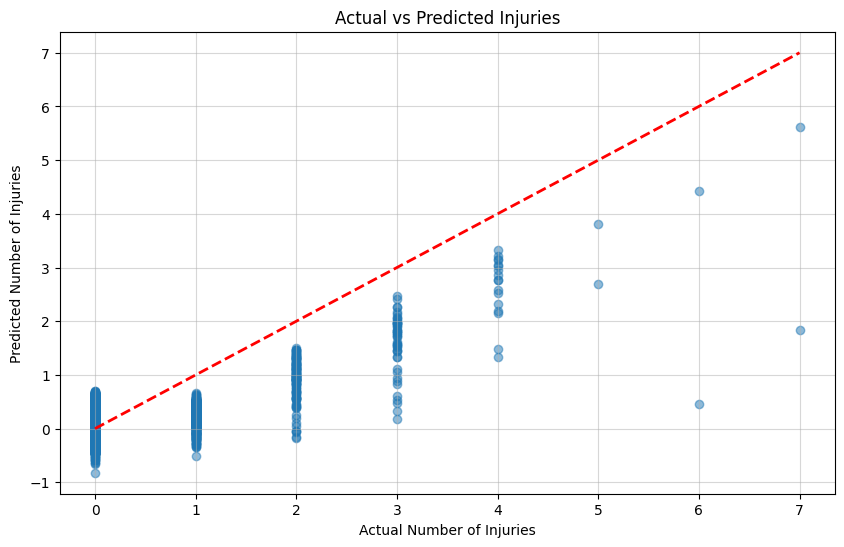

partial regression plot (training set):


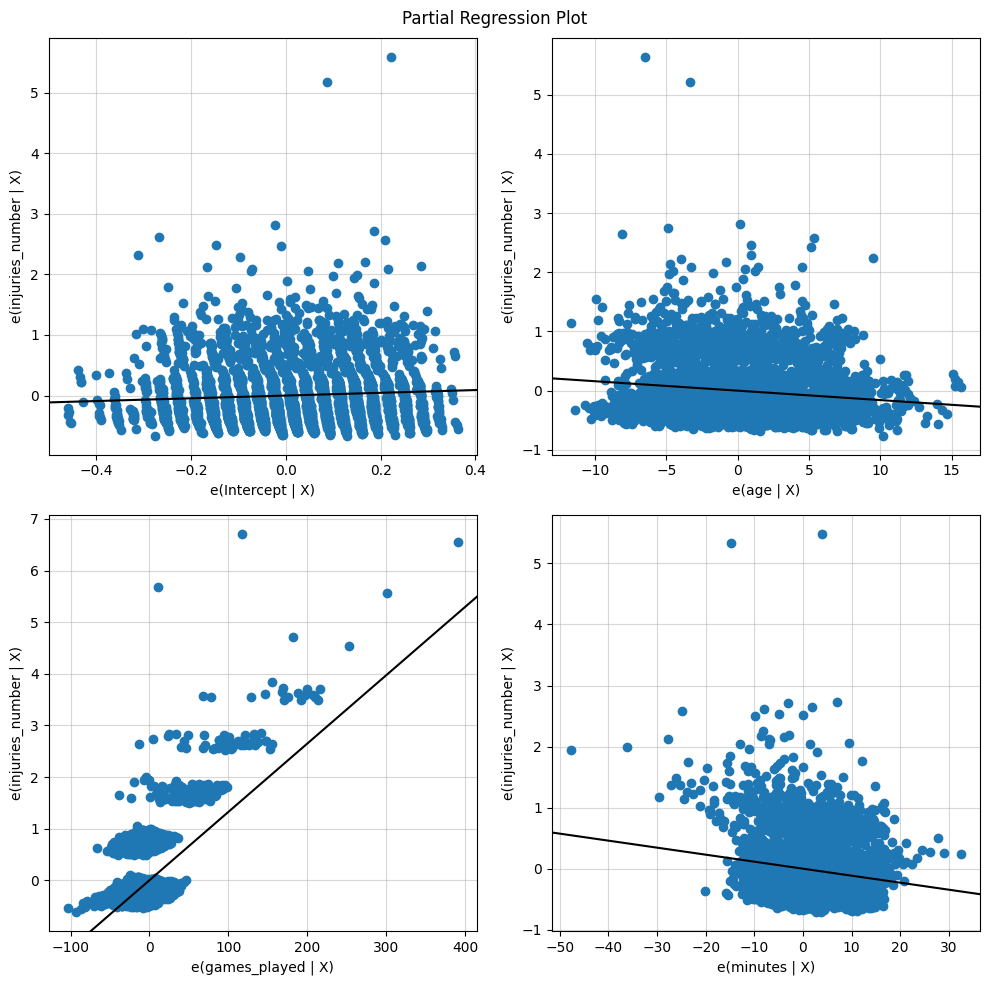

multiple regression plot (test set):


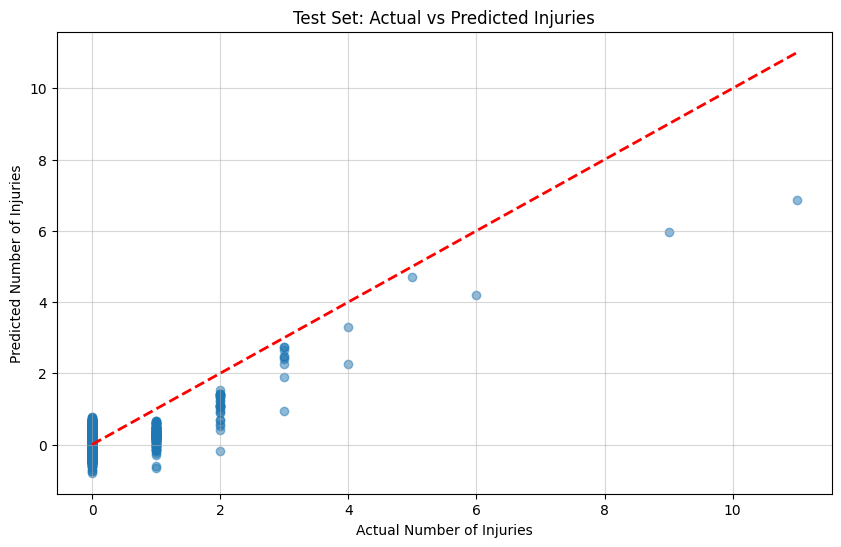

partial regression plot (test set):


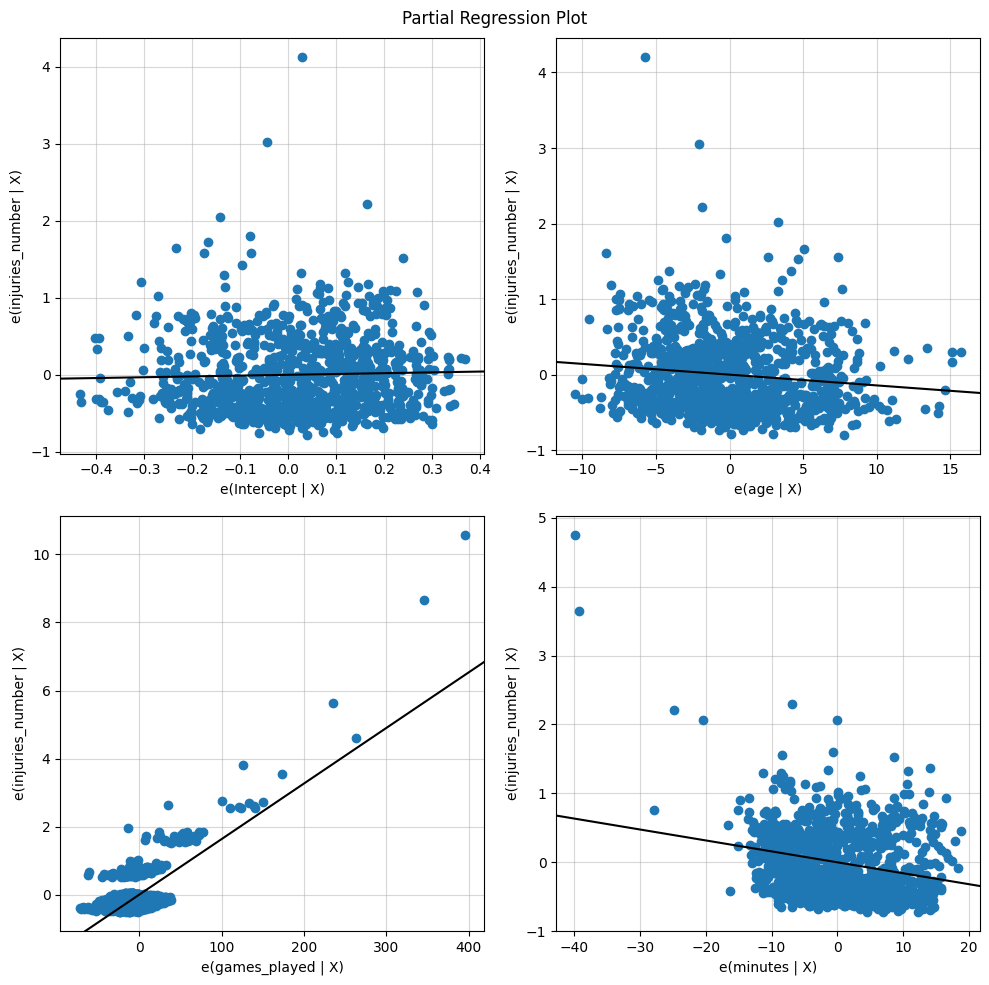

In [ ]:
multiple_regression_result(
    res_train, res_test, injuries_multiple, test_data, train_data
)

### Multiple regression on number of injuries by injury type

In [89]:
injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[(db["PLAYER_ID"] == p) & (db["INJURED_TYPE"] == i)]),
        'age': db[db["PLAYER_ID"] == p]["AGE"].iloc[0],
        'games_played': db[(db["PLAYER_ID"] == p)]["GP"].sum(),
        'minutes': db[(db["PLAYER_ID"] == p)]["MIN"].mean(),
    }
    for p in db["PLAYER_ID"].unique()
    for i in db[db["PLAYER_ID"] == p]["INJURED_TYPE"].unique()
])

train_data, test_data = train_test_split(injuries_multiple, test_size=0.2, random_state=42)

res_train = sm.ols('injuries_number ~ age + games_played + minutes', data=train_data).fit()
res_test = sm.ols('injuries_number ~ age + games_played + minutes', data=test_data).fit()

AttributeError: module 'statsmodels.api' has no attribute 'ols'

Training Set:
                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     211.4
Date:                Sat, 17 May 2025   Prob (F-statistic):          9.20e-116
Time:                        17:21:16   Log-Likelihood:                -2284.7
No. Observations:                1627   AIC:                             4577.
Df Residuals:                    1623   BIC:                             4599.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9949      0.180

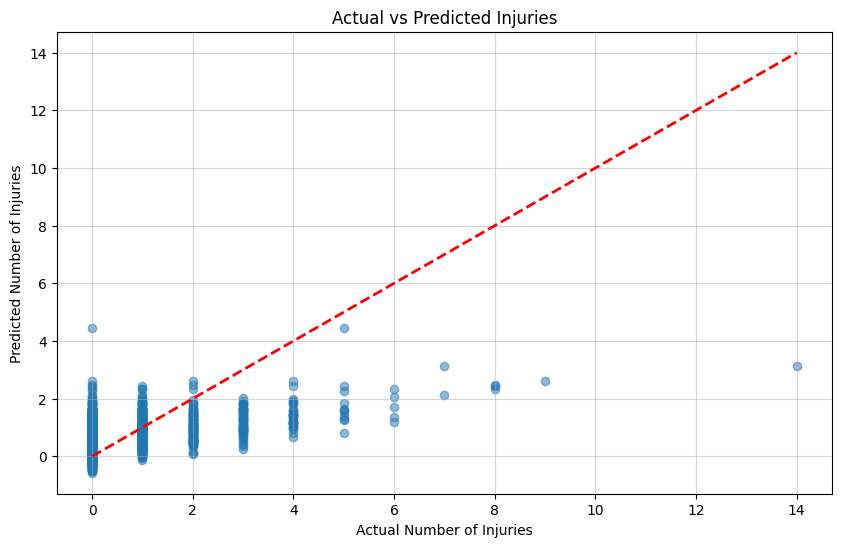

partial regression plot (training set):


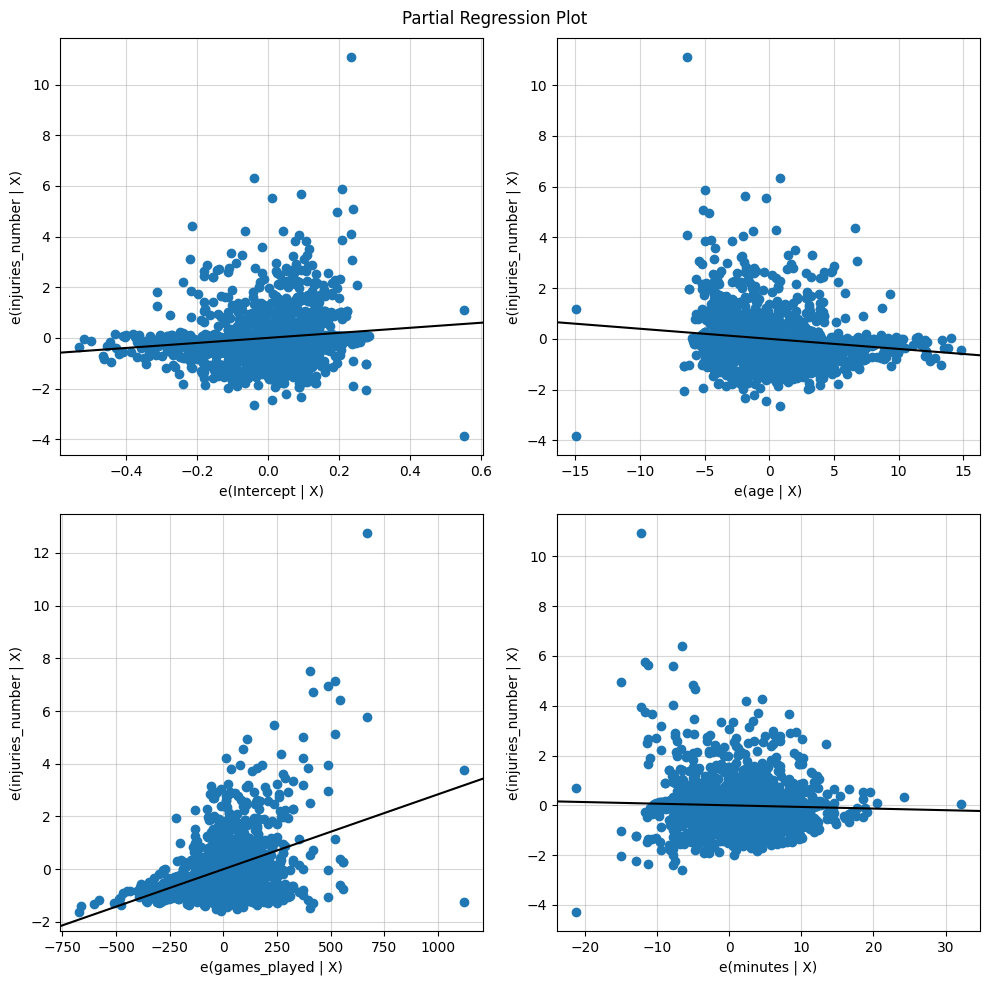

multiple regression plot (test set):


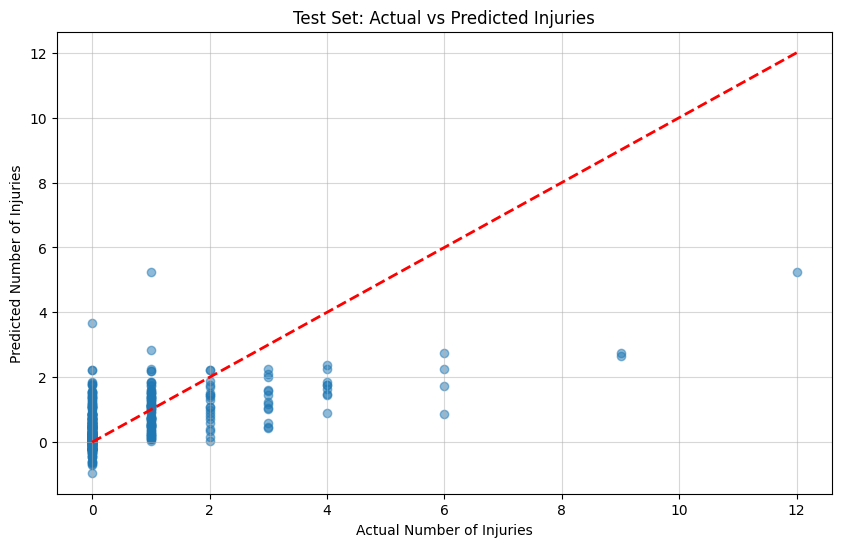

partial regression plot (test set):


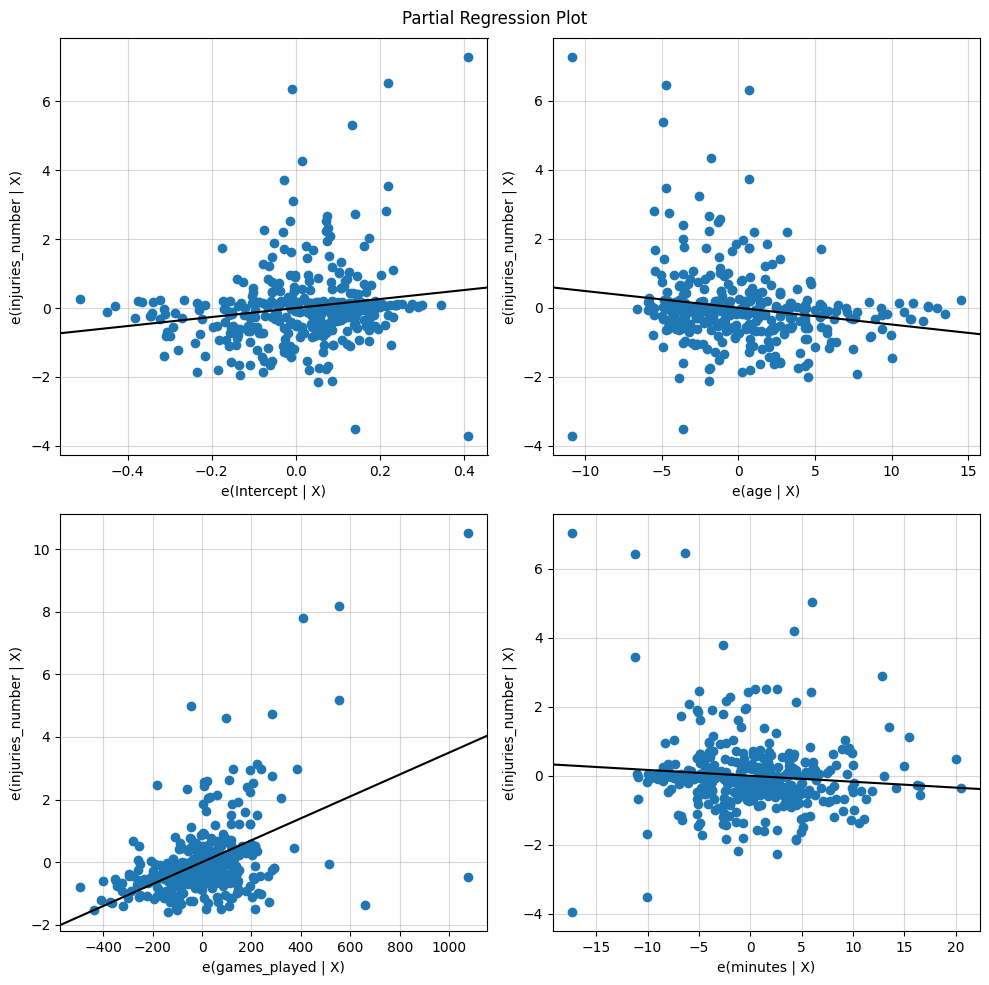

In [ ]:
multiple_regression_result(
    res_train, res_test, injuries_multiple, test_data, train_data
)

## Targeted multiple linear regression

Training Set:
                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     7.568
Date:                Sun, 18 May 2025   Prob (F-statistic):           8.58e-05
Time:                        10:49:44   Log-Likelihood:                -229.34
No. Observations:                 182   AIC:                             466.7
Df Residuals:                     178   BIC:                             479.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.4187      2.082

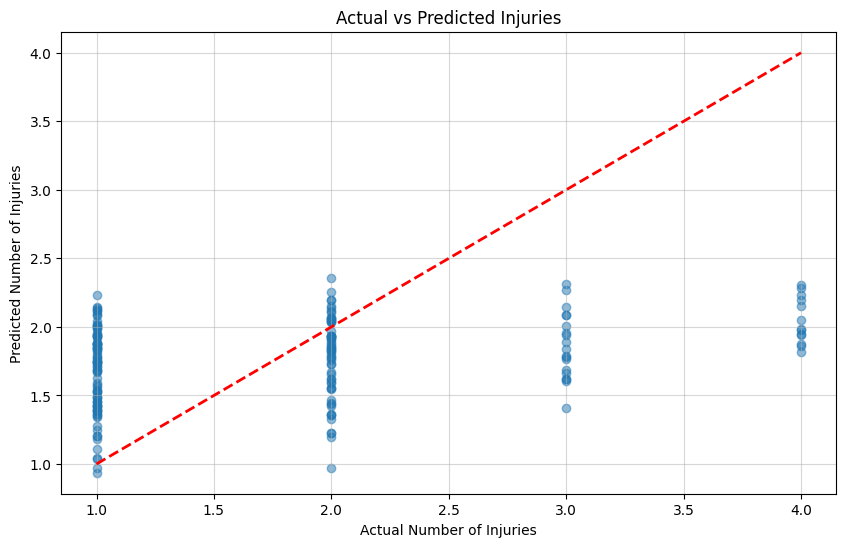

partial regression plot (training set):


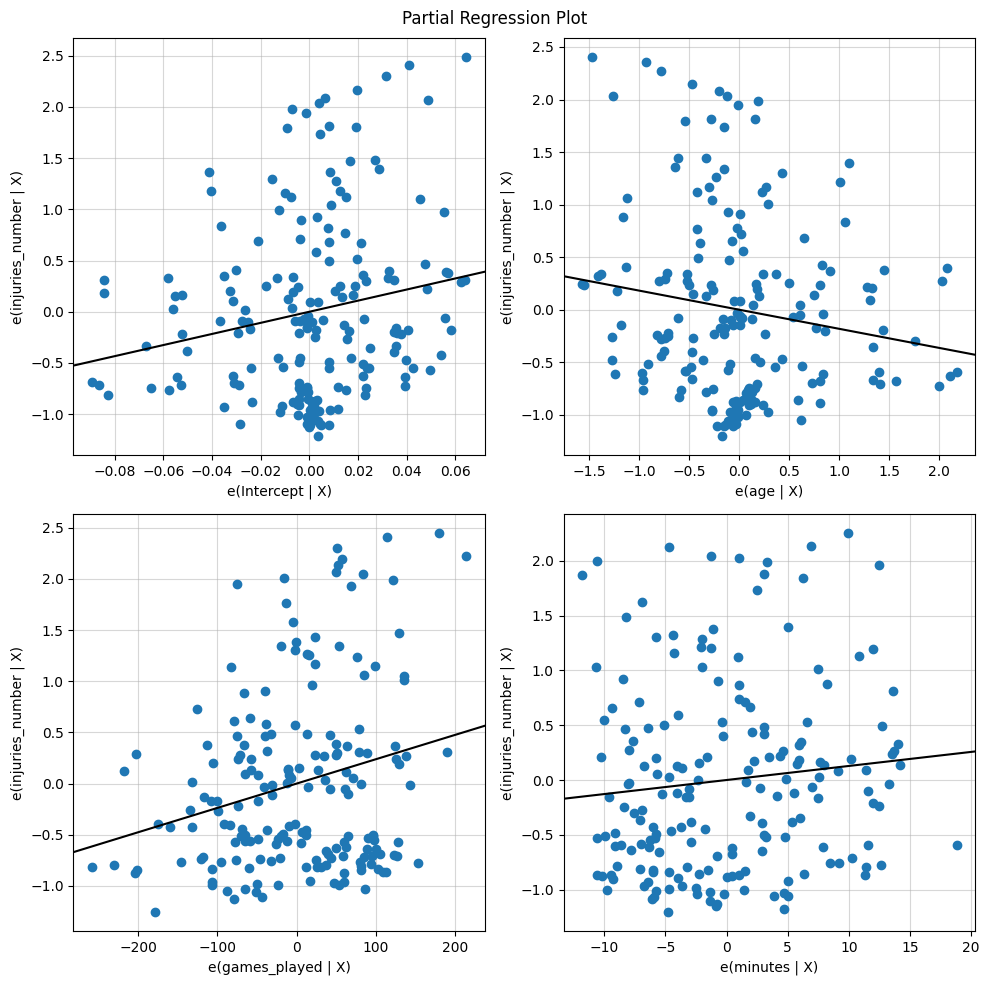

multiple regression plot (test set):


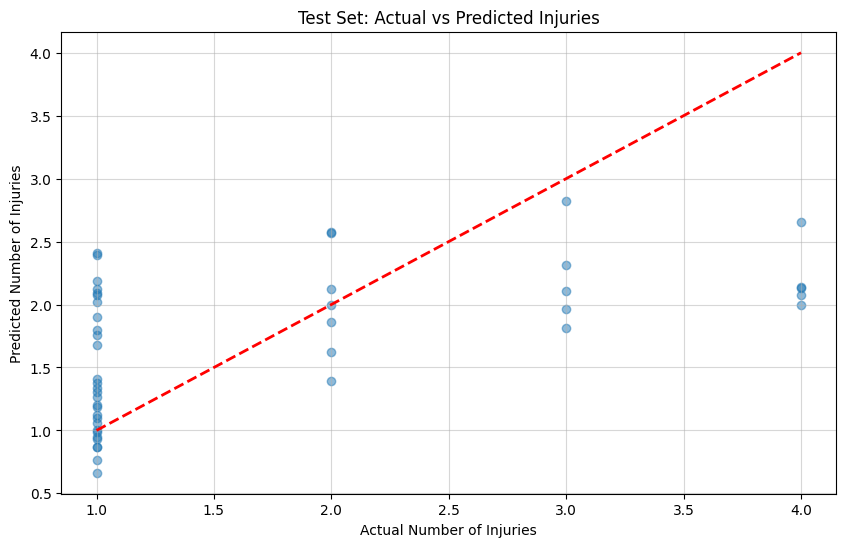

partial regression plot (test set):


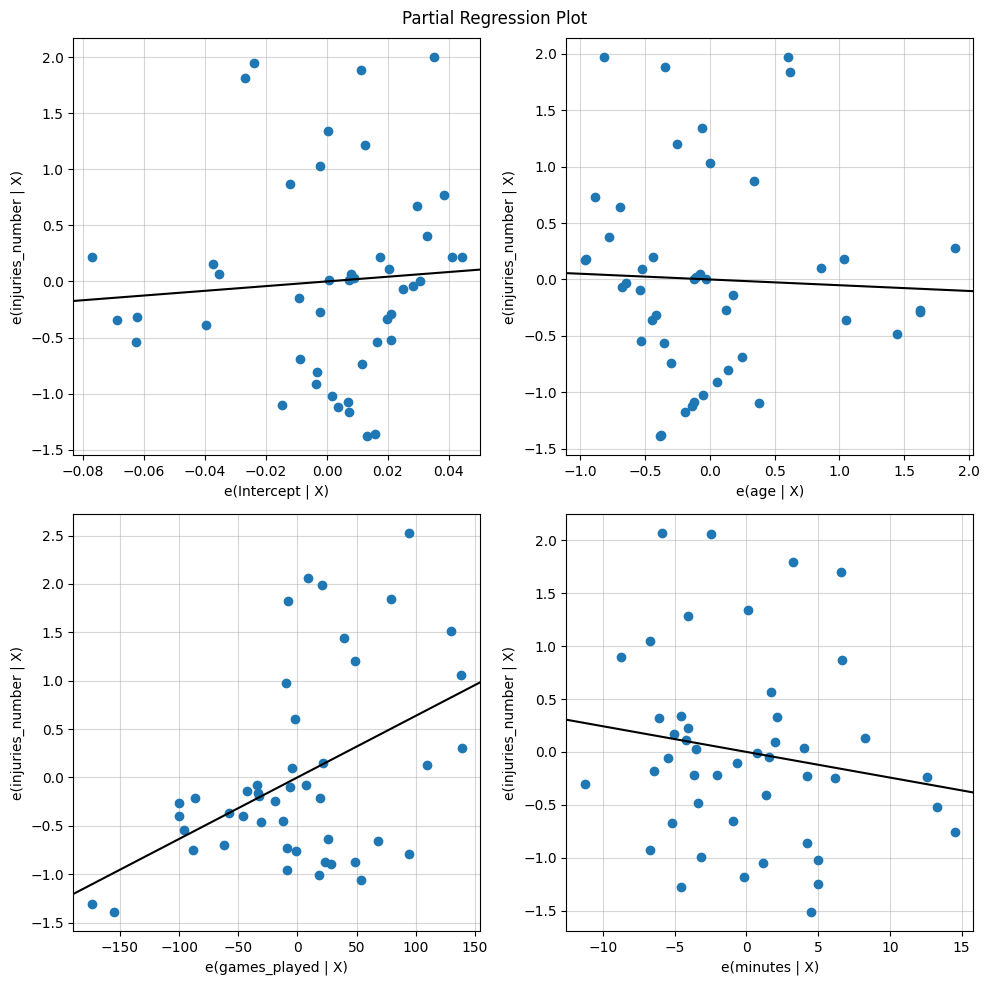

In [ ]:
target_ages = list(range(23, 28))

injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[(db["PLAYER_ID"] == p) & (db["INJURED_TYPE"].notna()) & (db["AGE"].isin(target_ages))]),
        'age': db[(db["PLAYER_ID"] == p) & (db["AGE"].isin(target_ages))]["AGE"].mean(),
        'games_played': db[(db["PLAYER_ID"] == p) & (db["AGE"].isin(target_ages))]["GP"].sum(),
        'minutes': db[(db["PLAYER_ID"] == p) & (db["AGE"].isin(target_ages))]["MIN"].mean(),
    }
    for p in db[db["AGE"].isin(target_ages)]["PLAYER_ID"].unique()
    if len(db[(db["PLAYER_ID"] == p) & (db["INJURED_TYPE"].notna()) & (db["AGE"].isin(target_ages))]) in range(1, 5)
])

train_data, test_data = train_test_split(injuries_multiple, test_size=0.2, random_state=42)
    
res_train = sm.ols('injuries_number ~ age + games_played + minutes', data=train_data).fit()
res_test = sm.ols('injuries_number ~ age + games_played + minutes', data=test_data).fit()

multiple_regression_result(
    res_train, res_test, injuries_multiple, test_data, train_data
)

# pd.DataFrame(injuries_multiple["injuries_number"].value_counts()).head(15)

Training Set:
                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     18.74
Date:                Sun, 18 May 2025   Prob (F-statistic):           5.87e-11
Time:                        10:51:53   Log-Likelihood:                -361.23
No. Observations:                 245   AIC:                             730.5
Df Residuals:                     241   BIC:                             744.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.6603      1.045

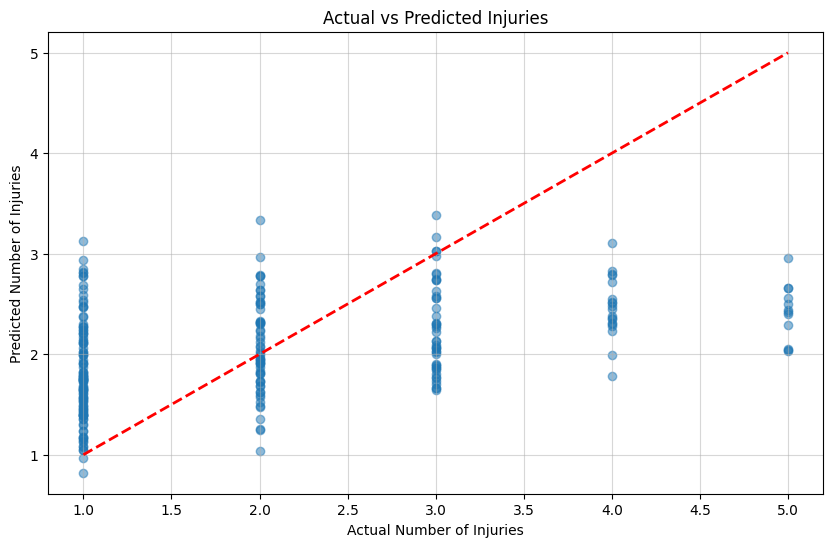

partial regression plot (training set):


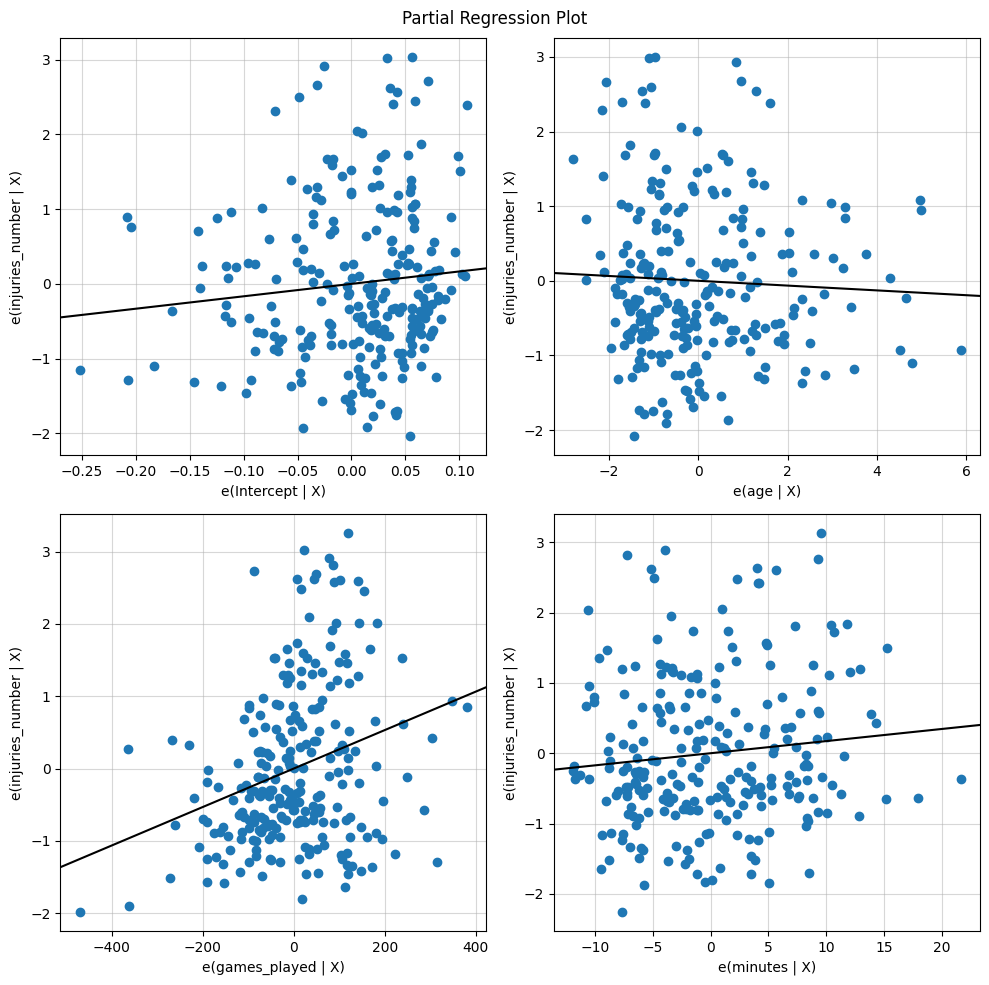

multiple regression plot (test set):


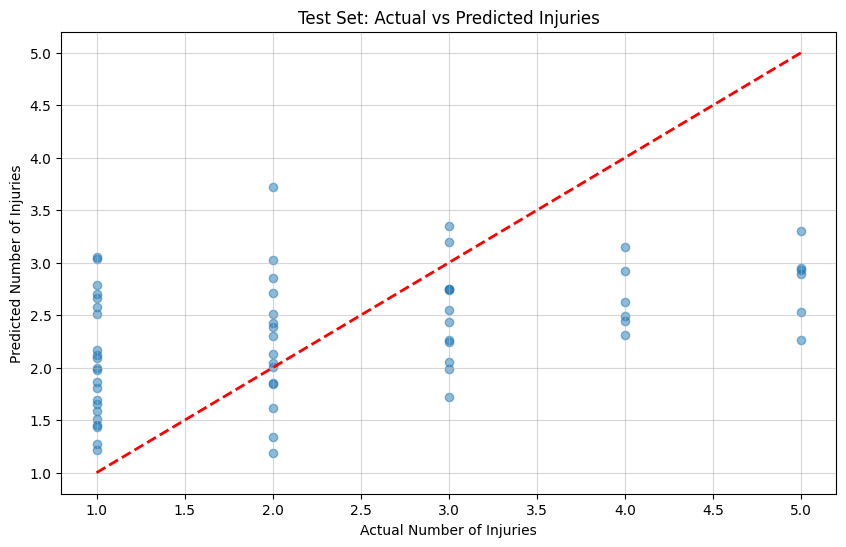

partial regression plot (test set):


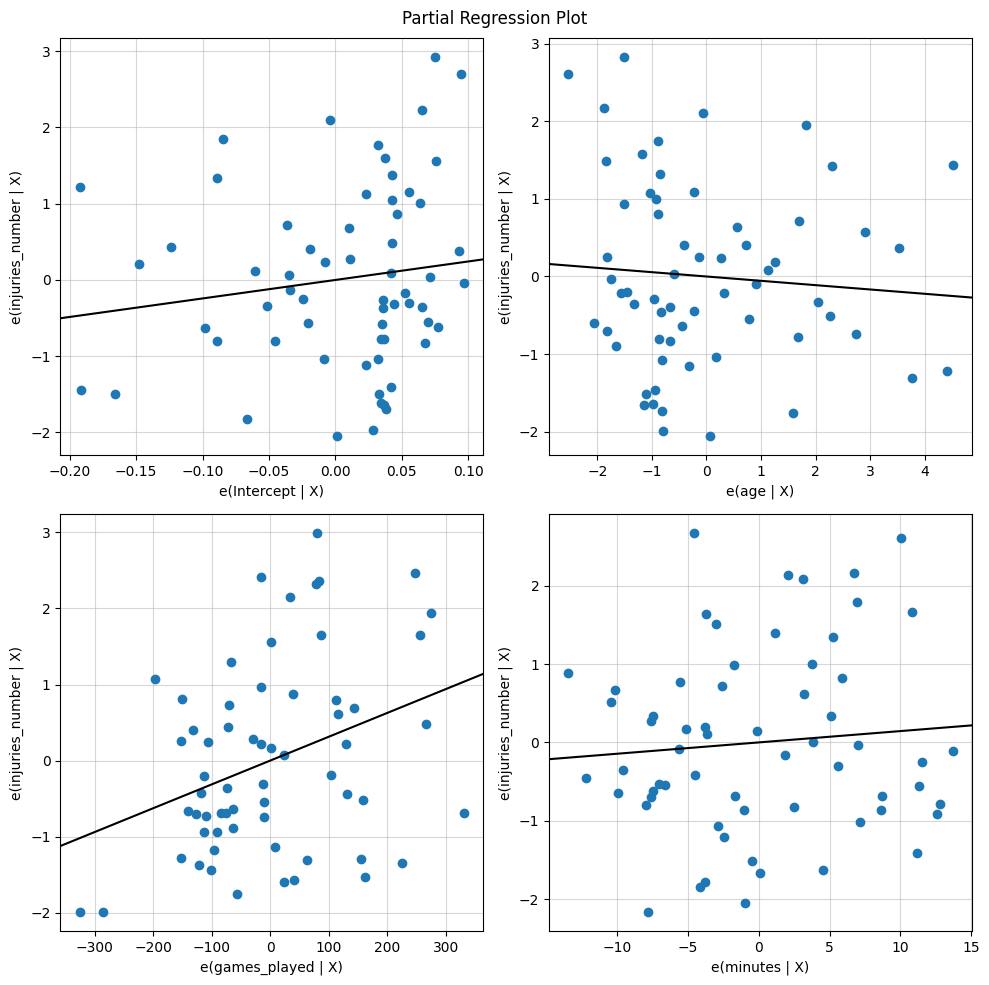

In [ ]:
target_ages = list(range(22, 31))

injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[(db["PLAYER_ID"] == p) & (db["INJURED_TYPE"].notna()) & (db["AGE"].isin(target_ages))]),
        'age': db[(db["PLAYER_ID"] == p) & (db["AGE"].isin(target_ages))]["AGE"].mean(),
        'games_played': db[(db["PLAYER_ID"] == p) & (db["AGE"].isin(target_ages))]["GP"].sum(),
        'minutes': db[(db["PLAYER_ID"] == p) & (db["AGE"].isin(target_ages))]["MIN"].mean(),
    }
    for p in db[db["AGE"].isin(target_ages)]["PLAYER_ID"].unique()
    if len(db[(db["PLAYER_ID"] == p) & (db["INJURED_TYPE"].notna()) & (db["AGE"].isin(target_ages))]) in range(1, 6)
])

train_data, test_data = train_test_split(injuries_multiple, test_size=0.2, random_state=42)
    
res_train = sm.ols('injuries_number ~ age + games_played + minutes', data=train_data).fit()
res_test = sm.ols('injuries_number ~ age + games_played + minutes', data=test_data).fit()

multiple_regression_result(
    res_train, res_test, injuries_multiple, test_data, train_data
)

## Multiple logistic regression

In [94]:
injuries_multiple_outcome = pd.DataFrame([
    {
        'has_injuries': len(db[(db["PLAYER_ID"] == p) & (db["INJURED_TYPE"].notna())]) > 0,
        'age': db[db["PLAYER_ID"] == p]["AGE"].iloc[0],
        'games_played': db[db["PLAYER_ID"] == p]["GP"].sum(),
        'minutes': db[db["PLAYER_ID"] == p]["MIN"].mean(),
    }
    for p in db["PLAYER_ID"].unique()
])

print("Class distribution:")
print(injuries_multiple_outcome['has_injuries'].value_counts())

Class distribution:
has_injuries
False    994
True     397
Name: count, dtype: int64


In [95]:
# Split data into train and test sets
train_data, test_data = train_test_split(injuries_multiple_outcome, test_size=0.2, random_state=42, stratify=injuries_multiple_outcome['has_injuries'])

# Prepare features and target for training
X_train = train_data[['games_played', 'minutes']]
y_train = train_data['has_injuries']

# Prepare features and target for testing 
X_test = test_data[['games_played', 'minutes']]
y_test = test_data['has_injuries']

# Fit logistic regression model
lm = linear_model.LogisticRegression(solver='lbfgs')
lm.fit(X_train, y_train)

# Make predictions on both train and test sets
train_probabilities = lm.predict_proba(X_train)
train_pred = lm.predict(X_train)
test_probabilities = lm.predict_proba(X_test)
test_pred = lm.predict(X_test)

# Add predictions to dataframes
train_data['predicted_prob'] = train_probabilities[:, 1]
train_data['predicted'] = train_pred
test_data['predicted_prob'] = test_probabilities[:, 1]
test_data['predicted'] = test_pred

# Calculate accuracy score on test data
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Training accuracy: {accuracy_score(y_train, train_pred):.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

train_data.head()

Training accuracy: 0.8147
Test accuracy: 0.8208


,has_injuries,age,games_played,minutes,predicted_prob,predicted
1094,False,33.0,215,20.000000,0.296949,False
864,False,23.0,8,12.300000,0.075812,False
342,False,22.0,44,13.500000,0.097807,False
321,True,25.0,221,15.600000,0.265123,False
631,False,35.0,629,25.155556,0.876657,True


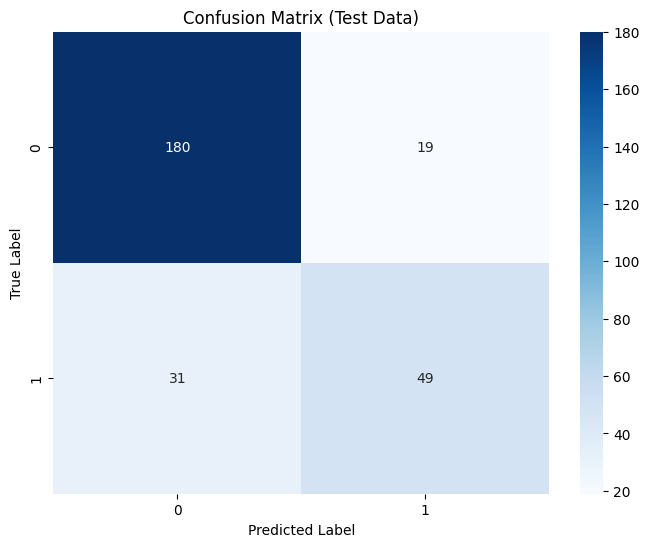

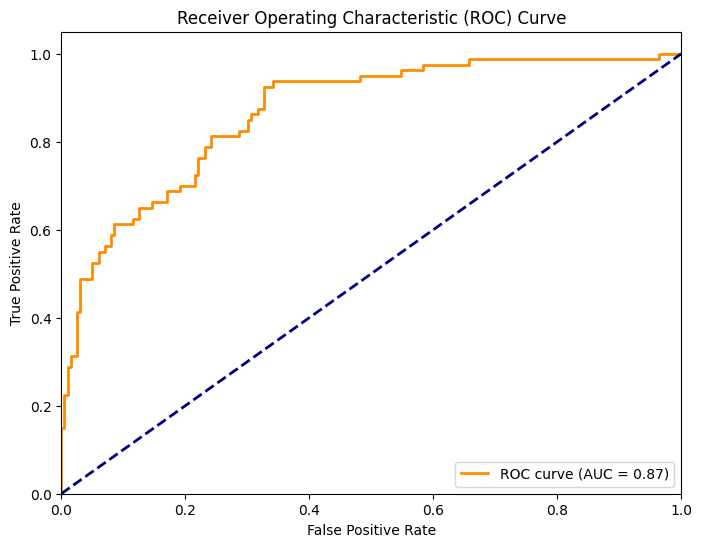

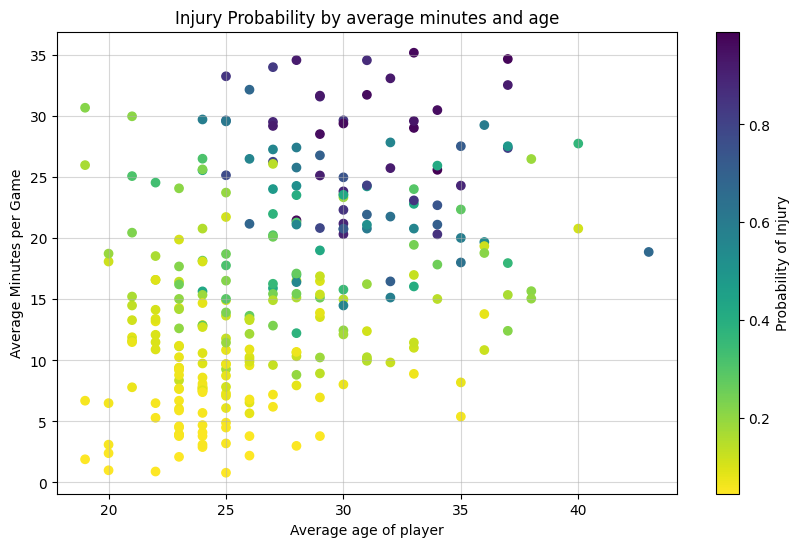


Classification Report:
              precision    recall  f1-score   support

       False       0.85      0.90      0.88       199
        True       0.72      0.61      0.66        80

    accuracy                           0.82       279
   macro avg       0.79      0.76      0.77       279
weighted avg       0.82      0.82      0.82       279



In [96]:
# Create confusion matrix for test data
cm = confusion_matrix(y_test, test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_probabilities[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Create scatter plot of features with prediction probabilities
plt.figure(figsize=(10, 6))
scatter = plt.scatter(test_data['age'], test_data['minutes'], 
                     c=test_probabilities[:, 1], cmap='viridis_r')
plt.colorbar(scatter, label='Probability of Injury')
plt.xlabel('Average age of player')
plt.ylabel('Average Minutes per Game')
plt.title('Injury Probability by average minutes and age')
plt.grid(alpha=0.5)
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, test_pred))


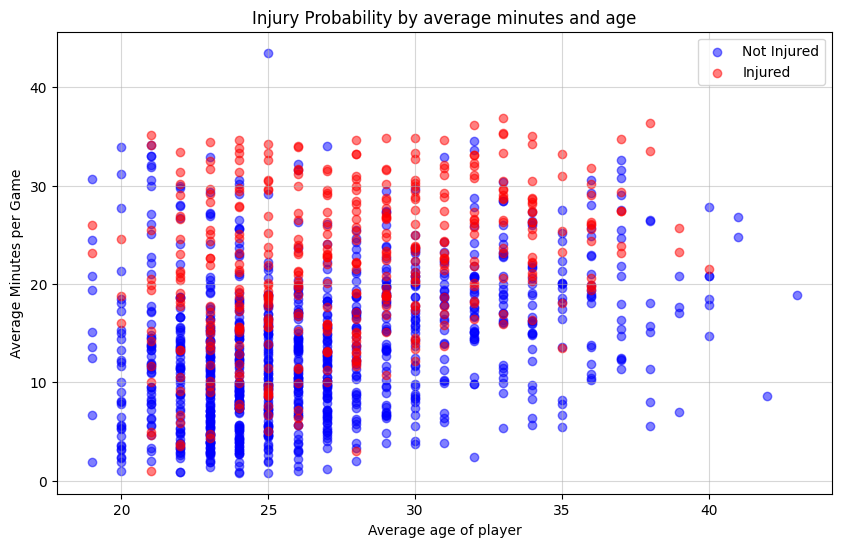

In [105]:
plt.figure(figsize=(10, 6))
plt.scatter(injuries_multiple_outcome[injuries_multiple_outcome['has_injuries'] == False]['age'], injuries_multiple_outcome[injuries_multiple_outcome['has_injuries'] == False]['minutes'], c="blue", label="Not Injured", alpha=0.5)
scatter = plt.scatter(injuries_multiple_outcome[injuries_multiple_outcome['has_injuries'] == True]['age'], injuries_multiple_outcome[injuries_multiple_outcome['has_injuries'] == True]['minutes'], c="red", label="Injured", alpha=0.5)
plt.xlabel('Average age of player')
plt.ylabel('Average Minutes per Game')
plt.title('Injury Probability by average minutes and age')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

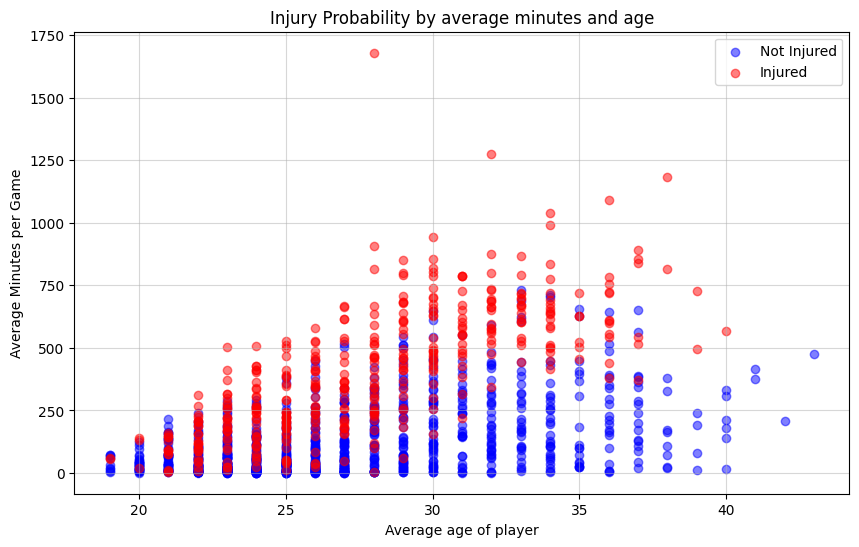

In [106]:
plt.figure(figsize=(10, 6))
plt.scatter(injuries_multiple_outcome[injuries_multiple_outcome['has_injuries'] == False]['age'], injuries_multiple_outcome[injuries_multiple_outcome['has_injuries'] == False]['games_played'], c="blue", label="Not Injured", alpha=0.5)
scatter = plt.scatter(injuries_multiple_outcome[injuries_multiple_outcome['has_injuries'] == True]['age'], injuries_multiple_outcome[injuries_multiple_outcome['has_injuries'] == True]['games_played'], c="red", label="Injured", alpha=0.5)
plt.xlabel('Average age of player')
plt.ylabel('Average Minutes per Game')
plt.title('Injury Probability by average minutes and age')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

Multiple Regression: Does a previous injury increase the likelihood of future injuries in NBA players? 

In [19]:
# amount of injuries per player
injury_counts = db.groupby("PLAYER_ID")["INJURED_TYPE"].count().reset_index()
injury_counts.rename(columns={"INJURED_TYPE": "total_injuries"}, inplace=True)

no_injury = (injury_counts["total_injuries"] == 0).sum()
one_injury = (injury_counts["total_injuries"] == 1).sum()
multiple_injuries = (injury_counts["total_injuries"] > 1).sum()

print(f"Players without injury: {no_injury}")
print(f"Players with one injury: {one_injury}")
print(f"Players with multiple injuries: {multiple_injuries}")

one_injury = injury_counts[injury_counts["total_injuries"] == 1].shape[0]
multiple_injuries = injury_counts[injury_counts["total_injuries"] > 1].shape[0]

# calculate the reinjury rate
reinjury_rate = multiple_injuries / (one_injury + multiple_injuries)
print(f"reinjury rate: {reinjury_rate:.2f}")



Players without injury: 994
Players with one injury: 147
Players with multiple injuries: 250
reinjury rate: 0.63
